In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ALL_2018.csv")

In [45]:
df.head()

,Unnamed: 0,station,ID,DATE,TMP,TMP_0:06,TMP_0:09,TMP_0:12,TMP_0:15,TMP_0:18,...,TMP_1:21,TMP_2:00,TMP_2:03,TMP_2:06,TMP_2:09,TMP_2:12,TMP_2:18,TMP_3:00,TEMP,TMPF
0,0,KABE,USW00014737,2018-04-01,107,48.50,48.75,48.75,48.25,46.50,...,43.50,43.25,43.50,44.00,46.00,47.50,51.75,53.5,10.7,51.26
1,1,KABE,USW00014737,2018-04-02,41,39.50,39.25,39.25,40.00,39.75,...,50.75,51.25,53.00,52.00,51.25,48.75,45.00,41.5,4.1,39.38
2,2,KABE,USW00014737,2018-04-03,30,39.75,41.25,42.25,43.75,45.00,...,42.00,40.75,39.25,38.00,38.50,38.50,39.50,41.0,3.0,37.40
3,3,KABE,USW00014737,2018-04-04,68,47.75,49.00,47.50,45.75,43.75,...,40.50,41.25,41.75,42.75,44.50,45.25,47.25,44.5,6.8,44.24
4,4,KABE,USW00014737,2018-04-05,37,37.50,38.25,37.50,38.50,38.50,...,46.25,45.50,43.25,41.75,40.00,38.75,35.75,35.5,3.7,38.66


In [32]:
# convert 10th of a degree to degree F
df['TMPF'] = (df['TMP']/10) *(9/5) + 32

In [33]:
temps = ['TMPF', 'TMP_0:06', 'TMP_0:09','TMP_0:12', 'TMP_0:15', 'TMP_0:18', 'TMP_0:21', 'TMP_1:00', 'TMP_1:03',
       'TMP_1:06', 'TMP_1:09', 'TMP_1:12', 'TMP_1:15', 'TMP_1:18', 'TMP_1:21',
       'TMP_2:00', 'TMP_2:03', 'TMP_2:06', 'TMP_2:09', 'TMP_2:12', 'TMP_2:18',
       'TMP_3:00']

## Plot JFK to check

/opt/conda/envs/cuny-summer-2020/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


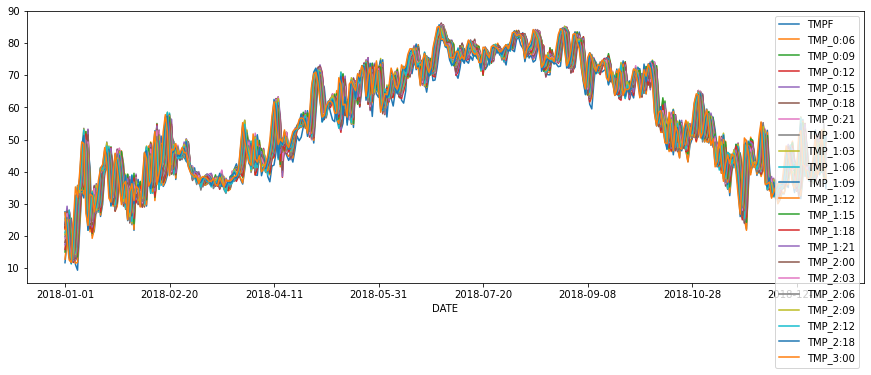

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
for col in temps:
    station = df[df['station'].str.match('KJFK')][['DATE',col]].set_index('DATE')
    station.plot(ax=ax, label=col)
ax.legend()

# Plot Observation Grids

In [43]:
df[temps].min()

TMPF       -39.82
TMP_0:06   -34.50
TMP_0:09   -33.50
TMP_0:12   -31.75
TMP_0:15   -32.25
TMP_0:18   -33.00
TMP_0:21   -34.75
TMP_1:00   -35.25
TMP_1:03   -35.50
TMP_1:06   -35.50
TMP_1:09   -34.50
TMP_1:12   -33.50
TMP_1:15   -33.25
TMP_1:18   -33.00
TMP_1:21   -34.00
TMP_2:00   -35.00
TMP_2:03   -35.25
TMP_2:06   -36.25
TMP_2:09   -36.25
TMP_2:12   -35.50
TMP_2:18   -35.00
TMP_3:00   -37.50
dtype: float64

In [44]:
df[temps].max()

TMPF        105.08
TMP_0:06    104.75
TMP_0:09    104.50
TMP_0:12    104.00
TMP_0:15    104.50
TMP_0:18    104.75
TMP_0:21    104.50
TMP_1:00    104.25
TMP_1:03    104.25
TMP_1:06    104.00
TMP_1:09    104.50
TMP_1:12    105.00
TMP_1:15    105.00
TMP_1:18    104.75
TMP_1:21    104.75
TMP_2:00    104.25
TMP_2:03    104.50
TMP_2:06    104.75
TMP_2:09    104.25
TMP_2:12    104.00
TMP_2:18    104.00
TMP_3:00    104.75
dtype: float64

In [48]:
for col in temps:
    temp_grid = df[['station', 'DATE', col]].pivot(index='station', columns='DATE', values=col)
    fig, ax = plt.subplots()
    ax.set_title(col)
    im = ax.pcolormesh(te, cmap='RdBu')
    ax.set(ylabel="stations", xlabel="day of year")
    ax.set_yticklabels([]) # removed individual station ids cause not super helpful here
    ax.tick_params(axis='y', length=0)
    fig.colorbar(im, ax=ax)

DATE     2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
station                                                               
KABE            NaN         NaN         NaN         NaN         NaN   
KABI          15.44       19.22       26.78       37.58       43.52   
KABQ          33.26       37.40       37.04       39.02       37.94   
KABR         -20.38      -10.84        3.56        5.36        8.06   
KACT          24.62       25.52       28.58       34.16       44.60   
...             ...         ...         ...         ...         ...   
PAYA            NaN       44.42       42.44       34.88       34.52   
PHLI          72.68       73.04       73.94       73.94       73.76   
PHNL          74.48       76.28       75.20       76.10       75.74   
PHOG          69.98       70.34       72.14       68.72       72.50   
PHTO          70.70       69.26       70.34       71.06       72.32   

DATE     2018-01-06  2018-01-07  2018-01-08  2018-01-09  2018-01-10  ...  \
